# Build Time-networks based on year of first PMID for an edge

We will build networks representing the state of knowledge at different timepoints.  This will be done by filtering edges by date, using the PMID associated with the earliest timepoint for each given edge.

In [1]:
import os
import pickle
import pandas as pd
from tqdm import tqdm, tqdm_pandas

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')

import sys
sys.path.append('../../hetnet-ml/src')
import graph_tools as gt

## Build a final ID to year map

Each map came from a different source, so make sure they are consistent in type

In [2]:
nlm = pickle.load(open('../data/pmid_to_year_NLM.pkl', 'rb'))
pmc = pickle.load(open('../data/pmid_to_year_PMC.pkl', 'rb'))
eur = pickle.load(open('../data/pmid_to_year_Eur.pkl', 'rb'))
ebi = pickle.load(open('../data/pmid_to_year_EBI.pkl', 'rb'))

There may be type differences between these maps, lets check.  
Ideally we want, `key=str: value=int`.

In [3]:
key = list(nlm.keys())[0]
value = nlm[key]
print('{!r}: {!r}'.format(key, value))

'115848': '1979'


`{str: str}`

In [4]:
key = list(pmc.keys())[0]
value = pmc[key]
print('{!r}: {!r}'.format(key, value))

'25834679': 2015


`{str: int}`

In [5]:
key = list(eur.keys())[0]
value = eur[key]
print('{!r}: {!r}'.format(key, value))

'24094408': '2013'


`{str: str}`

In [6]:
key = list(ebi.keys())[0]
value = ebi[key]
print('{!r}: {!r}'.format(key, value))

'24354032': '2014-03-21'


`{str: str}` with year formatted as `YYYY-MM-DD`

#### Reformatting the maps

`{str: int}` with only the year is the most useful for our purposes, so format all of these maps to this schema

In [7]:
for k, v in tqdm(nlm.items()):
    nlm[k] = int(v)

100%|██████████| 27836723/27836723 [00:19<00:00, 1398045.69it/s]


In [8]:
for k, v in tqdm(eur.items()):
    eur[k] = int(v)

100%|██████████| 3561213/3561213 [00:02<00:00, 1428090.24it/s]


In [9]:
for k, v in tqdm(ebi.items()):
    ebi[k] = int(v.split('-')[0])

100%|██████████| 7937/7937 [00:00<00:00, 909816.64it/s]


In [10]:
# order of importance right to left. (pmc values will replace all others)
id_to_year = {**eur, **nlm, **ebi, **pmc}
id_to_year = {str(k): v for k, v in id_to_year.items()}

## Bring in the nodes and edges files

In [11]:
tqdm.pandas()

In [12]:
nodes = gt.remove_colons(pd.read_csv('../data/nodes_VER31_R_cons_6_metanode.csv'))
nodes.head(2)

,id,name,label,id_source
0,C0229664,peripheral blood,Anatomy,UMLS
1,C0545822,"Esophagus, stomach and duodenum",Anatomy,UMLS


In [13]:
edges = gt.remove_colons(pd.read_csv('../data/edges_VER31_R_cons_6_metanode.csv'))
edges['pmids'] = edges['pmids'].progress_apply(eval)
edges.head(2)

100%|██████████| 7784275/7784275 [01:41<00:00, 76902.70it/s] 


,start_id,end_id,type,pmids,n_pmids
0,D010447,D010519,AFFECTS_CDafA,"{10920248, 19040577}",2
1,D008239,D022781,AFFECTS_CDafA,"{496661, 21106925, 6696070}",3


## Edge type breakdown by PMID count in final network

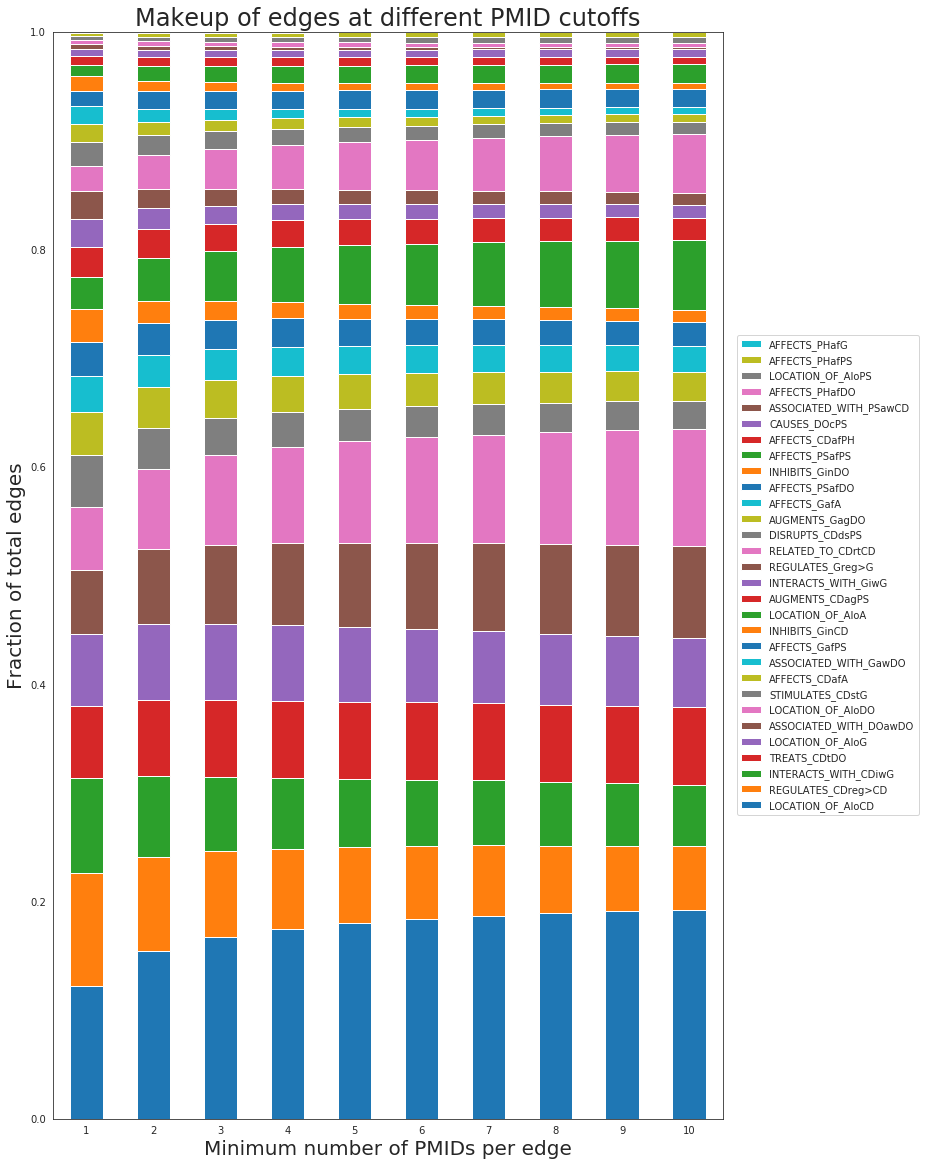

In [14]:
frame = pd.DataFrame()
for i in range(10):

    to_plot = edges.query('n_pmids > @i')['type'].value_counts()
    to_plot = to_plot / to_plot.sum()
    frame[i+1] = to_plot
    
    
fig = frame.T.plot.bar(stacked=True, figsize=(12, 20))
handels, labels = fig.axes.get_legend_handles_labels()
plt.legend(handels[::-1], labels[::-1], loc=7, bbox_to_anchor=(1.3, 0.5))
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.title('Makeup of edges at different PMID cutoffs', size=24)
plt.xlabel('Minimum number of PMIDs per edge', size=20)
plt.ylabel('Fraction of total edges', size = 20);

## Now apply the ID to Year Map

In [15]:
# turn pmids into a list so order is preserved
edges['pmids'] = edges['pmids'].apply(list)
edges.head(2)

,start_id,end_id,type,pmids,n_pmids
0,D010447,D010519,AFFECTS_CDafA,"[10920248, 19040577]",2
1,D008239,D022781,AFFECTS_CDafA,"[496661, 21106925, 6696070]",3


In [16]:
# Ideally just want minimum year for a given edge, so supplying 9999 for not found pmids will
# allow min() to be used on the resulting list.
edges['pub_years'] = edges['pmids'].progress_apply(lambda pmids: [id_to_year.get(str(p), 9999) for p in pmids])
edges.head(2)

100%|██████████| 7784275/7784275 [00:47<00:00, 165153.11it/s]


,start_id,end_id,type,pmids,n_pmids,pub_years
0,D010447,D010519,AFFECTS_CDafA,"[10920248, 19040577]",2,"[2000, 2008]"
1,D008239,D022781,AFFECTS_CDafA,"[496661, 21106925, 6696070]",3,"[1979, 2010, 1984]"


In [17]:
edges['first_pub'] = edges['pub_years'].progress_apply(min)
edges.head(2)

100%|██████████| 7784275/7784275 [00:13<00:00, 594119.15it/s]


,start_id,end_id,type,pmids,n_pmids,pub_years,first_pub
0,D010447,D010519,AFFECTS_CDafA,"[10920248, 19040577]",2,"[2000, 2008]",2000
1,D008239,D022781,AFFECTS_CDafA,"[496661, 21106925, 6696070]",3,"[1979, 2010, 1984]",1979


## Now the get the dates from the gold standard.

In [18]:
indications = pd.read_csv('../data/indications_nodemerge.csv')
indications.head(2)

,id,struct_id,concept_id,relationship_name,disease_name,umls_cui,snomed_full_name,cui_semantic_type,snomed_conceptid,compound_name,compound_semmed_id,disease_semmed_id,approval_date,approval_year
0,173432,965,40249340,indication,Malignant tumor of breast,C0006142,Malignant tumor of breast,T191,254837009.0,drostanolone propionate,C007561,DOID:1612,NaN,NaN
1,173433,318,21000716,indication,Gout,C0018099,Gout,T047,90560007.0,benzbromarone,D001553,DOID:13189,NaN,NaN


In [19]:
len(indications)

8279

Some NA values in the date, won't be useul for this analysis so just drop them

In [20]:
indications.dropna(subset=['approval_year'], inplace=True)
indications['approval_year'] = indications['approval_year'].astype(int)

In [21]:
len(indications)

7100

## Filter nodes and edges by year to build the network

In [22]:
base_dir = '../data/time_networks-6_metanode'

In [23]:
def get_year_category(diff):
    if diff > 20:
        return '20+ After'
    elif diff >= 15 and diff < 20:
        return '15-20 After'
    elif diff >= 10 and diff < 15:
        return '10-15 After'
    elif diff >= 5 and diff < 10:
        return '5-10 After'
    elif diff >= 0 and diff < 5:
        return '0-5 After'
    elif diff >= -5 and diff < 0:
        return '0-5 Before'
    elif diff >= -10 and diff < -5:
        return '5-10 Before'
    elif diff >= -15 and diff < -10:
        return '10-15 Before'
    elif diff >= -20 and diff < -15:
        return '15-20 Before'
    elif diff < -20:
        return '20+ Before'

In [24]:
def plot_figure(indications, year, out_dir):
    
    order = ['20+ Before',
         '15-20 Before',
         '10-15 Before',
         '5-10 Before',
         '0-5 Before',
         '0-5 After',
         '5-10 After',
         '10-15 After',
         '15-20 After',
         '20+ After']
    
    
    plt.clf()
    plt.figure(figsize=(6, 4.5))

    f = sns.countplot(x='year_cat', data=indications, order=order)
    
    plt.ylabel('Count')
    plt.xlabel('Years from approval and {}'.format(year))
    plt.xticks(rotation=45)

    xlim = f.axes.get_xlim()
    x_mid = (xlim[1] + xlim[0]) / 2

    tick_diff = f.get_yticks()[1] - f.get_yticks()[0]
    y_height = f.get_yticks()[-2] - tick_diff/5 

    plt.text(3*x_mid/2, y_height, 'Total indications:\n          {}'.format(len(indications)))


    plt.title('Distribution of approval years for {}'.format(year))
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, 'ind-distribution.png'));

In [ ]:
for year in tqdm(range(1950, 2021, 1)):

    # Define the save directory
    out_dir = os.path.join(base_dir, str(year))

    # Make sure the save directory exists, if not, make it
    try:
        os.stat(out_dir)
    except:
        os.makedirs(out_dir)       
    
    # Filter the edges by year
    e_filt = edges.query('first_pub <= @year')

    # Keep only nodes that have edges joining them
    node_ids = set(e_filt['start_id']).union(set(e_filt['end_id']))
    n_filt = nodes.query('id in @node_ids')

    # Keep only indications that have both the compound and disease still existing in the network
    ind_filt = indications.query('compound_semmed_id in @node_ids and disease_semmed_id in @node_ids').reset_index(drop=True)

    # Determine the difference between the current year and approval
    ind_filt['year_diff'] = ind_filt['approval_year'] - year
    ind_filt['year_cat'] = ind_filt['year_diff'].apply(get_year_category)

    print("Year: {}\nIDs: {:,}\nNodes: {:,}\nEdges: {:,}\nIndications: {:,}\n\n".format(
        year, len(node_ids), len(n_filt), len(e_filt), len(ind_filt)))
    
    # Save the network, indications, and summary figure
    (gt.add_colons(n_filt, id_name='cui')
       .to_csv(os.path.join(out_dir, 'nodes.csv'), index=False))
    (gt.add_colons(e_filt, col_types={'n_pmids':'INT', 'first_pub':'INT'})
       .to_csv(os.path.join(out_dir, 'edges.csv'), index=False))
    ind_filt.to_csv(os.path.join(out_dir, 'indications.csv'), index=False)
    #plot_figure(ind_filt, year, out_dir);

  0%|          | 0/71 [00:00<?, ?it/s]

Year: 1950
IDs: 8,760
Nodes: 8,760
Edges: 32,132
Indications: 702




  1%|▏         | 1/71 [00:03<04:10,  3.58s/it]

Year: 1951
IDs: 9,685
Nodes: 9,685
Edges: 38,316
Indications: 767




  3%|▎         | 2/71 [00:05<03:34,  3.10s/it]

Year: 1952
IDs: 10,517
Nodes: 10,517
Edges: 44,232
Indications: 848




  4%|▍         | 3/71 [00:07<03:09,  2.79s/it]

Year: 1953
IDs: 11,346
Nodes: 11,346
Edges: 50,218
Indications: 917




  6%|▌         | 4/71 [00:09<02:50,  2.55s/it]

Year: 1954
IDs: 12,070
Nodes: 12,070
Edges: 55,995
Indications: 992




  7%|▋         | 5/71 [00:11<02:39,  2.42s/it]

Year: 1955
IDs: 12,789
Nodes: 12,789
Edges: 62,045
Indications: 1,121




  8%|▊         | 6/71 [00:14<02:37,  2.43s/it]

Year: 1956
IDs: 13,486
Nodes: 13,486
Edges: 67,886
Indications: 1,256




 10%|▉         | 7/71 [00:16<02:33,  2.40s/it]

Year: 1957
IDs: 14,193
Nodes: 14,193
Edges: 74,010
Indications: 1,294




 11%|█▏        | 8/71 [00:19<02:37,  2.50s/it]

Year: 1958
IDs: 14,912
Nodes: 14,912
Edges: 80,073
Indications: 1,551




 13%|█▎        | 9/71 [00:21<02:36,  2.52s/it]

Year: 1959
IDs: 15,625
Nodes: 15,625
Edges: 86,241
Indications: 1,639




 14%|█▍        | 10/71 [00:24<02:37,  2.58s/it]

Year: 1960
IDs: 16,327
Nodes: 16,327
Edges: 92,536
Indications: 1,756




 15%|█▌        | 11/71 [00:27<02:47,  2.80s/it]

Year: 1961
IDs: 17,052
Nodes: 17,052
Edges: 99,392
Indications: 1,822




 17%|█▋        | 12/71 [00:31<02:57,  3.01s/it]

Year: 1962
IDs: 17,863
Nodes: 17,863
Edges: 106,707
Indications: 1,921




 18%|█▊        | 13/71 [00:34<02:56,  3.04s/it]

Year: 1963
IDs: 18,716
Nodes: 18,716
Edges: 114,824
Indications: 2,025




 20%|█▉        | 14/71 [00:37<02:59,  3.15s/it]

Year: 1964
IDs: 19,672
Nodes: 19,672
Edges: 123,918
Indications: 2,126




 21%|██        | 15/71 [00:41<03:01,  3.25s/it]

Year: 1965
IDs: 20,631
Nodes: 20,631
Edges: 133,854
Indications: 2,187




 23%|██▎       | 16/71 [00:45<03:07,  3.41s/it]

Year: 1966
IDs: 21,651
Nodes: 21,651
Edges: 144,660
Indications: 2,265




 24%|██▍       | 17/71 [00:48<03:11,  3.54s/it]

Year: 1967
IDs: 22,724
Nodes: 22,724
Edges: 156,604
Indications: 2,312




 25%|██▌       | 18/71 [00:53<03:18,  3.74s/it]

Year: 1968
IDs: 23,861
Nodes: 23,861
Edges: 169,468
Indications: 2,387




 27%|██▋       | 19/71 [00:57<03:23,  3.92s/it]

Year: 1969
IDs: 25,037
Nodes: 25,037
Edges: 183,150
Indications: 2,476




 28%|██▊       | 20/71 [01:02<03:29,  4.10s/it]

Year: 1970
IDs: 26,194
Nodes: 26,194
Edges: 197,535
Indications: 2,550




 30%|██▉       | 21/71 [01:07<03:39,  4.39s/it]

Year: 1971
IDs: 27,423
Nodes: 27,423
Edges: 212,861
Indications: 2,690




 31%|███       | 22/71 [01:12<03:45,  4.59s/it]

Year: 1972
IDs: 28,638
Nodes: 28,638
Edges: 228,774
Indications: 2,786




 32%|███▏      | 23/71 [01:17<03:50,  4.80s/it]

Year: 1973
IDs: 29,831
Nodes: 29,831
Edges: 245,384
Indications: 2,857




 34%|███▍      | 24/71 [01:23<03:57,  5.04s/it]

Year: 1974
IDs: 31,131
Nodes: 31,131
Edges: 263,507
Indications: 2,957




 35%|███▌      | 25/71 [01:28<04:03,  5.29s/it]

Year: 1975
IDs: 34,637
Nodes: 34,637
Edges: 320,145
Indications: 3,076




 37%|███▋      | 26/71 [01:35<04:16,  5.70s/it]

Year: 1976
IDs: 37,748
Nodes: 37,748
Edges: 377,969
Indications: 3,236




 38%|███▊      | 27/71 [01:42<04:31,  6.18s/it]

Year: 1977
IDs: 40,303
Nodes: 40,303
Edges: 430,123
Indications: 3,352




 39%|███▉      | 28/71 [01:50<04:45,  6.65s/it]

Year: 1978
IDs: 42,717
Nodes: 42,717
Edges: 482,739
Indications: 3,428




 41%|████      | 29/71 [01:58<04:59,  7.12s/it]

Year: 1979
IDs: 45,112
Nodes: 45,112
Edges: 538,632
Indications: 3,496




 42%|████▏     | 30/71 [02:07<05:15,  7.70s/it]

Year: 1980
IDs: 47,613
Nodes: 47,613
Edges: 600,155
Indications: 3,637




 44%|████▎     | 31/71 [02:17<05:36,  8.41s/it]

Year: 1981
IDs: 50,106
Nodes: 50,106
Edges: 665,613
Indications: 3,712




 45%|████▌     | 32/71 [02:28<05:50,  8.98s/it]

Year: 1982
IDs: 52,640
Nodes: 52,640
Edges: 736,492
Indications: 3,856




 46%|████▋     | 33/71 [02:39<06:02,  9.55s/it]

Year: 1983
IDs: 55,359
Nodes: 55,359
Edges: 819,785
Indications: 3,950




 48%|████▊     | 34/71 [02:51<06:20, 10.29s/it]

Year: 1984
IDs: 58,258
Nodes: 58,258
Edges: 909,498
Indications: 4,075




 49%|████▉     | 35/71 [03:03<06:32, 10.91s/it]

Year: 1985
IDs: 61,017
Nodes: 61,017
Edges: 1,004,502
Indications: 4,171




 51%|█████     | 36/71 [03:18<07:04, 12.13s/it]

Year: 1986
IDs: 63,575
Nodes: 63,575
Edges: 1,104,204
Indications: 4,245




 52%|█████▏    | 37/71 [03:32<07:12, 12.71s/it]

Year: 1987
IDs: 66,332
Nodes: 66,332
Edges: 1,208,485
Indications: 4,290




 54%|█████▎    | 38/71 [03:47<07:19, 13.33s/it]

Year: 1988
IDs: 69,084
Nodes: 69,084
Edges: 1,317,483
Indications: 4,389




 55%|█████▍    | 39/71 [04:03<07:30, 14.06s/it]

Year: 1989
IDs: 72,200
Nodes: 72,200
Edges: 1,444,650
Indications: 4,478




 56%|█████▋    | 40/71 [04:19<07:40, 14.84s/it]

Year: 1990
IDs: 75,302
Nodes: 75,302
Edges: 1,575,901
Indications: 4,586




 58%|█████▊    | 41/71 [04:38<08:03, 16.13s/it]

Year: 1991
IDs: 78,297
Nodes: 78,297
Edges: 1,712,147
Indications: 4,639




 59%|█████▉    | 42/71 [04:57<08:06, 16.76s/it]

Year: 1992
IDs: 81,400
Nodes: 81,400
Edges: 1,857,605
Indications: 4,687




 61%|██████    | 43/71 [05:16<08:07, 17.42s/it]

Year: 1993
IDs: 84,420
Nodes: 84,420
Edges: 2,006,637
Indications: 4,729




 62%|██████▏   | 44/71 [05:36<08:10, 18.18s/it]

Year: 1994
IDs: 87,544
Nodes: 87,544
Edges: 2,167,083
Indications: 4,772




 63%|██████▎   | 45/71 [05:56<08:14, 19.00s/it]

Year: 1995
IDs: 90,705
Nodes: 90,705
Edges: 2,336,569
Indications: 4,882




 65%|██████▍   | 46/71 [06:21<08:35, 20.63s/it]

Year: 1996
IDs: 93,780
Nodes: 93,780
Edges: 2,515,942
Indications: 4,911




 66%|██████▌   | 47/71 [06:44<08:35, 21.49s/it]

Year: 1997
IDs: 96,566
Nodes: 96,566
Edges: 2,683,221
Indications: 4,954




 68%|██████▊   | 48/71 [07:08<08:31, 22.26s/it]

Year: 1998
IDs: 99,591
Nodes: 99,591
Edges: 2,873,814
Indications: 5,030




 69%|██████▉   | 49/71 [07:34<08:31, 23.24s/it]

Year: 1999
IDs: 102,504
Nodes: 102,504
Edges: 3,068,494
Indications: 5,076




 70%|███████   | 50/71 [08:01<08:29, 24.26s/it]

Year: 2000
IDs: 105,381
Nodes: 105,381
Edges: 3,267,627
Indications: 5,102




 72%|███████▏  | 51/71 [08:30<08:38, 25.94s/it]

Year: 2001
IDs: 108,350
Nodes: 108,350
Edges: 3,477,303
Indications: 5,149




 73%|███████▎  | 52/71 [09:00<08:31, 26.91s/it]

Year: 2002
IDs: 111,176
Nodes: 111,176
Edges: 3,697,783
Indications: 5,178




 75%|███████▍  | 53/71 [09:30<08:22, 27.90s/it]

Year: 2003
IDs: 113,834
Nodes: 113,834
Edges: 3,925,492
Indications: 5,203




 76%|███████▌  | 54/71 [10:01<08:11, 28.93s/it]

Year: 2004
IDs: 116,382
Nodes: 116,382
Edges: 4,156,878
Indications: 5,219




 77%|███████▋  | 55/71 [10:34<08:02, 30.18s/it]

Year: 2005
IDs: 118,537
Nodes: 118,537
Edges: 4,401,455
Indications: 5,239




 79%|███████▉  | 56/71 [11:11<08:01, 32.09s/it]

Year: 2006
IDs: 120,265
Nodes: 120,265
Edges: 4,641,341
Indications: 5,241




 80%|████████  | 57/71 [11:46<07:42, 33.03s/it]

Year: 2007
IDs: 121,869
Nodes: 121,869
Edges: 4,885,904
Indications: 5,272




 82%|████████▏ | 58/71 [12:23<07:24, 34.18s/it]

Year: 2008
IDs: 123,443
Nodes: 123,443
Edges: 5,132,386
Indications: 5,306




 83%|████████▎ | 59/71 [13:03<07:10, 35.91s/it]

Year: 2009
IDs: 124,975
Nodes: 124,975
Edges: 5,385,037
Indications: 5,312




 85%|████████▍ | 60/71 [13:42<06:44, 36.75s/it]

Year: 2010
IDs: 126,417
Nodes: 126,417
Edges: 5,642,719
Indications: 5,313




 86%|████████▌ | 61/71 [14:23<06:22, 38.23s/it]

Year: 2011
IDs: 127,779
Nodes: 127,779
Edges: 5,910,826
Indications: 5,314




 87%|████████▋ | 62/71 [15:06<05:55, 39.55s/it]

Year: 2012
IDs: 129,156
Nodes: 129,156
Edges: 6,186,444
Indications: 5,327




 89%|████████▊ | 63/71 [15:49<05:25, 40.68s/it]

Year: 2013
IDs: 130,461
Nodes: 130,461
Edges: 6,473,709
Indications: 5,327




 90%|█████████ | 64/71 [16:34<04:53, 41.87s/it]

Year: 2014
IDs: 131,767
Nodes: 131,767
Edges: 6,766,340
Indications: 5,328


